# Large Scale Experiments

Importing libraries:

In [1]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from search_approaches import IVF
from utils import *

Defining constants:

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "sift"
DIR = "sift"
SEARCH_TRAIN_SUBSET = False
tab20 = matplotlib.colormaps["tab20"]
tab20c = matplotlib.colormaps["tab20c"]

Loading the data:

In [3]:
tr_data, search_data, queries, gt = load_data(
    dataset_name=DATASET,
    dataset_dir=DIR,
    search_train_subset=SEARCH_TRAIN_SUBSET,
    random_seed=RANDOM_SEED
)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))
print("Base vectors (to search in) shape: ", search_data.shape)
print(f"Base vectors (to search in) range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", tr_data.shape)
print("Query example:\n", queries[0])

Base vectors (to search in) shape:  (1000000, 128)
Base vectors (to search in) range: [0.0, 218.0]
Query vectors shape:  (10000, 128)
Ground truth shape:  (10000, 100)
Learn vectors shape:  (100000, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


Defining a function to compute the average recall at various values of R for a set of queries. Both the "nearest recall at R" and "recall at R" are computed: the former measures the proportion of query vectors for which the nearest neighbor is ranked in the first R positions, while the latter measures the average recall at R. In the original article, only "nearest recall at R is analyzed, with the authors noting that the conclusions are similar for recall at R.

In [4]:
def compute_recall(index, exact_ranks, R, queries, w):
    """
    Compute average recall at all values in R for the given index and queries.

    Parameters
    ----------

    index : PQ or IVF
        The index to use for the search.

    exact_ranks : np.ndarray
        The exact ranking of the search data for each query.

    R : list
        The list of values for which to compute the recall at.

    queries : np.ndarray
        The queries to use for the search.

    w : int
        The number of centroids to visit in the IVF index.

    Returns
    -------

    results : dict
        A dictionary containing the mean recall at each value of R for the
        asymmetric distance computation.
        Recall is computed both as the number of relevant items in the top R,
        and as the presence of the nearest item in the top R (nearest recall).
    
    """

    for r in R:
        if r > exact_ranks.shape[1]:
            raise ValueError(f"r={r} is greater than the number of ground truth neighbors")
    
    asym_recall = np.full((len(queries), len(R)), np.nan)
    nearest_asym_recall = np.full((len(queries), len(R)), np.nan)
    for i, query in enumerate(queries):
        _, asym_rank = index.search(query, w=w, asym=True, correct=False)
        for j, r in enumerate(R):
            if r <= len(asym_rank):
                asym_recall[i][j] = recall_at_r(asym_rank, exact_ranks[i], r)
                nearest_asym_recall[i][j] = exact_ranks[i][0] in asym_rank[:r]

    with warnings.catch_warnings(record=True) as w:
        asym_recall_mean = np.nanmean(asym_recall, axis=0)
        nearest_asym_recall_mean = np.nanmean(nearest_asym_recall, axis=0)
        if w:
            for warning in w:
                if "Mean of empty slice" not in str(warning.message):
                    warnings.warn(warning.message, warning.category)
    
    return {
        "asym_recall_mean": asym_recall_mean,
        "nearest_asym_recall_mean": nearest_asym_recall_mean
    }

Comparing the search performance and training time when using KMeans, MiniBatch Kmeans (with default parameters, i.e. `batch_size=1024`) and Bisecting KMeans for the coarse clustering. This is implemented by calling the IVF constructor and specifying the parameter `coarse_clust_alg`. Recall is evaluated only at 1 at maximum of 100 because the ground truth rankings provided by the dataset authors are limited to the top 100 nearest neighbors, and computing the full ranking would be computationally expensive.

In [5]:
K = 256
M = 8
KPs = [1024, 8192]
Ws = [8, 64]
R = [1, 2, 5, 10, 25, 50, 100]

results = []
for i, kp in enumerate(KPs):
    for clust_alg in ["km", "mkm", "bkm"]:
        ivf = IVF(Kp=kp, M=M, K=K, seed=RANDOM_SEED, coarse_clust_alg=clust_alg)
        print(f"Training IVFADC with k'={kp}, w={Ws[i]}, coarse_clust_alg={clust_alg}...")
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        print("Adding search data to IVFADC...")
        ivf.add(search_data, compute_distortions=True)
        print("Computing recall...")
        res = compute_recall(ivf, gt, R, queries, w=Ws[i])
        results.append({
            "k'" : kp,
            "coarse_clust_alg": clust_alg,
            "training_time": training_time,
            **res
        })

Training IVFADC with k'=1024, w=8, coarse_clust_alg=km...
Adding search data to IVFADC...
Computing recall...
Training IVFADC with k'=1024, w=8, coarse_clust_alg=mkm...
Adding search data to IVFADC...
Computing recall...
Training IVFADC with k'=1024, w=8, coarse_clust_alg=bkm...
Adding search data to IVFADC...
Computing recall...
Training IVFADC with k'=8192, w=64, coarse_clust_alg=km...
Adding search data to IVFADC...
Computing recall...
Training IVFADC with k'=8192, w=64, coarse_clust_alg=mkm...
Adding search data to IVFADC...
Computing recall...
Training IVFADC with k'=8192, w=64, coarse_clust_alg=bkm...
Adding search data to IVFADC...
Computing recall...


Plotting the results:

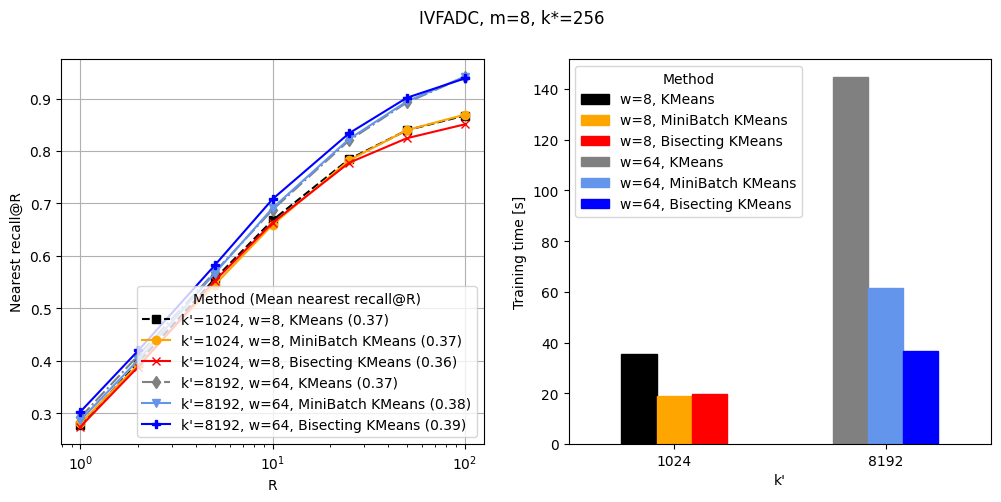

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

colors = ["black", "orange", "red", "gray", "cornflowerblue", "blue"]
markers = ["--s", "-o", "-x", "-.d", "-v", "-P"]
for i, res in enumerate(results):
    kp = res["k'"]
    w = Ws[KPs.index(kp)]
    if res["coarse_clust_alg"] == "km":
        coarse_clust_alg = "KMeans"
    elif res["coarse_clust_alg"] == "bkm":
        coarse_clust_alg = "Bisecting KMeans"
    else:
        coarse_clust_alg = "MiniBatch KMeans"
    mean_recall = np.nanmean(res['asym_recall_mean'])
    label = f"k'={kp}, w={w}, {coarse_clust_alg} ({mean_recall:.2f})"
    axs[0].plot(R, res["nearest_asym_recall_mean"], markers[i], label=label, color=colors[i])

axs[0].set_xscale('log')
axs[0].set_xlabel('R')
axs[0].set_ylabel('Nearest recall@R')
axs[0].legend(title="Method (Mean nearest recall@R)")
axs[0].grid()

times_df = pd.DataFrame({
    "k'": KPs,
    "Training time KMeans": [res["training_time"] for res in results if res["coarse_clust_alg"]=="km"],
    "Training time MiniBatch KMeans": [res["training_time"] for res in results if res["coarse_clust_alg"]=="mkm"],
    "Training time Bisecting KMeans": [res["training_time"] for res in results if res["coarse_clust_alg"]=="bkm"]
    })
times_df.set_index("k'", inplace=True)
ax = times_df.plot.bar(rot=0, ax=axs[1], legend=False)
for i, bar in enumerate(ax.patches):
    if i%2==0:
        bar.set_color(colors[:3][i//2])
    else:
        bar.set_color(colors[3:][i//2])
legend_patches = []
for i, res in enumerate(results):
    kp = res["k'"]
    w = Ws[KPs.index(kp)]
    if res["coarse_clust_alg"] == "km":
        coarse_clust_alg = "KMeans"
    elif res["coarse_clust_alg"] == "bkm":
        coarse_clust_alg = "Bisecting KMeans"
    else:
        coarse_clust_alg = "MiniBatch KMeans"
    label = f"w={w}, {coarse_clust_alg}"
    legend_patches.append(mpatches.Patch(color=colors[i], label=label))
ax.legend(handles=legend_patches, title="Method")
ax.set_ylabel("Training time [s]");

fig.suptitle(f"IVFADC, m={M}, k*={K}");